In [1]:
! pip install skforecast

In [2]:
# Procesado de datos
# ==============================================================================
import os
import pandas as pd
import numpy as np
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

# Keras
# ==============================================================================
os.environ["KERAS_BACKEND"] = "tensorflow" # 'tensorflow', 'jax´ or 'torch'
import keras
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

if keras.__version__ > "3.0":
    if keras.backend.backend() == "tensorflow":
        import tensorflow
    elif keras.backend.backend() == "torch":
        import torch
    else:
        print("Backend not recognized. Please use 'tensorflow' or 'torch'.")

# Modelado
# ==============================================================================
import skforecast
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

/home/khaosdev/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/khaosdev/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


: 

# RNN : EJEMPLO


In [5]:
# Descarga y procesado de datos
# ==============================================================================
air_quality = fetch_dataset(name="air_quality_valencia")

# Imputación de datos ausentes mediante interpolación lineal
# ==============================================================================
air_quality = air_quality.interpolate(method="linear")
air_quality = air_quality.sort_index()
air_quality.head()

air_quality_valencia
--------------------
Hourly measures of several air chemical pollutant (pm2.5, co, no, no2, pm10,
nox, o3, so2) at Valencia city.
 Red de Vigilancia y Control de la Contaminación Atmosférica, 46250054-València
- Centre, https://mediambient.gva.es/es/web/calidad-ambiental/datos-historicos.
Shape of the dataset: (26304, 10)


,pm2.5,co,no,no2,pm10,nox,o3,veloc.,direc.,so2
datetime,,,,,,,,,,
2019-01-01 00:00:00,19.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,8.0
2019-01-01 01:00:00,26.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,8.0
2019-01-01 02:00:00,31.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,8.0
2019-01-01 03:00:00,30.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,10.0
2019-01-01 04:00:00,30.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,11.0


In [6]:
# Split train-validation-test
# ==============================================================================
end_train = "2021-03-31 23:59:00"
end_validation = "2021-09-30 23:59:00"
air_quality_train = air_quality.loc[:end_train, :].copy()
air_quality_val = air_quality.loc[end_train:end_validation, :].copy()
air_quality_test = air_quality.loc[end_validation:, :].copy()

print(
    f"Fechas train      : {air_quality_train.index.min()} --- "
    f"{air_quality_train.index.max()}  (n={len(air_quality_train)})"
)
print(
    f"Fechas validation : {air_quality_val.index.min()} --- "
    f"{air_quality_val.index.max()}  (n={len(air_quality_val)})"
)
print(
    f"Fechas test       : {air_quality_test.index.min()} --- "
    f"{air_quality_test.index.max()}  (n={len(air_quality_test)})"
)

Fechas train      : 2019-01-01 00:00:00 --- 2021-03-31 23:00:00  (n=19704)
Fechas validation : 2021-04-01 00:00:00 --- 2021-09-30 23:00:00  (n=4392)
Fechas test       : 2021-10-01 00:00:00 --- 2021-12-31 23:00:00  (n=2208)


CREACIÓN MODELO:
model = create_and_compile_model(
    series=data_train,
    levels=levels,
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=4,
    dense_units=16,
    optimizer=Adam(learning_rate=0.01),
    loss=MeanSquaredError()
)

In [7]:
# Creación del modelo
# ==============================================================================
series = ["o3"] # Series temporales que se utilizarán para entrenar el modelo.
levels = ["o3"] # Serie que se quiere predecir
lags = 32 # Valores pasados a utilizar en la predicción
steps = 1 # Pasos a futuro a predecir

# Selección de las series temporales utilizadas
data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels,
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=4,
    dense_units=16,
    optimizer=Adam(learning_rate=0.01),
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 4)                   │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 1)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Creación del forecaster
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10,  # Número de épocas para entrenar el modelo.
        "batch_size": 32,  # Tamaño del batch para entrenar el modelo.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback para detener el entrenamiento cuando ya no esté aprendiendo más.
        "series_val": data_val,  # Datos de validación para el entrenamiento del modelo.
    },
)

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning:

Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.

/usr/local/lib/python3.10/dist-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning:

`steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.



In [9]:
# Entrenamiento del forecaster
# ==============================================================================
forecaster.fit(data_train)

predictions = forecaster.predict()


# Backtesting con datos de test
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]), # Datos de entrenamiento + validación
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)

Epoch 1/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0305 - val_loss: 0.0066
Epoch 2/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 3/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0056 - val_loss: 0.0070
Epoch 4/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0056 - val_loss: 0.0058
Epoch 5/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 6/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 7/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 8/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 9/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 10/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 1/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 2/10
752/752 ━━━━━━━━━━━━━━━━━━━━

  0%|          | 0/2208 [00:00<?, ?it/s]

In [10]:
# Error en % respecto a la media de la serie
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Media de la serie: {np.mean(data['o3']):0.2f}")
print(f"Error (mae) relativo: {rel_mse:0.2f} %")

Media de la serie: 54.52
Error (mae) relativo: 10.56 %


MULTISTEP FORECASTING:

In [11]:
# Creación del modelo
# ==============================================================================
series = ["o3"] # Series temporales que se utilizarán para entrenar el modelo.
levels = ["o3"] # Serie que se quiere predecir
lags = 32 # Valores pasados a utilizar en la predicción
steps = 5 # Pasos a futuro a predecir

model = create_and_compile_model(
    series=data_train,
    levels=levels,
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=50,
    dense_units=32,
    optimizer=Adam(learning_rate=0.01),
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             165 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 5, 1)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,197 (47.64 KB)

 Trainable params: 12,197 (47.64 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Creación del Forecaster
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 10,  # Número de épocas para entrenar el modelo.
        "batch_size": 32,  # Tamaño del batch para entrenar el modelo.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback para detener el entrenamiento cuando ya no esté aprendiendo más.
        "series_val": data_val,  # Datos de validación para el entrenamiento del modelo.
    },
)

# Entrenamiento del forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.0267 - val_loss: 0.0136
Epoch 2/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0130 - val_loss: 0.0130
Epoch 3/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 4/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0118 - val_loss: 0.0113
Epoch 5/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0115 - val_loss: 0.0117
Epoch 6/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0117 - val_loss: 0.0117
Epoch 7/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 8/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 9/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 10/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0111 - val_loss: 0.0112


In [14]:
# Predicción
# ==============================================================================
predictions = forecaster.predict()

In [15]:
# Backtesting con datos de test
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]), # Datos de entrenamiento + validación
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)

Epoch 1/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.0111 - val_loss: 0.0132
Epoch 2/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0109 - val_loss: 0.0110
Epoch 3/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0108 - val_loss: 0.0111
Epoch 4/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0108 - val_loss: 0.0110
Epoch 5/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 6/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 7/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0108 - val_loss: 0.0122
Epoch 8/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.0108 - val_loss: 0.0112
Epoch 9/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 10/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0106 - val_loss: 0.0107


  0%|          | 0/442 [00:00<?, ?it/s]

In [16]:
# Error mse en % respecto a la media de la serie
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Media de la serie: {np.mean(data['o3']):0.2f}")
print(f"Error mse relativo: {rel_mse:0.2f} %")

Media de la serie: 54.52
Error mse relativo: 16.61 %


In [17]:
# Creación del modelo
# ==============================================================================
# Series temporales utilizadas en el entrenamiento. Tiene que incluir la serie a predecir.
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.','so2']
levels = ["o3"] # Serie que se quiere predecir
lags = 32 # Valores pasados a utilizar en la predicción
steps = 5 # Pasos a futuro a predecir

# Selección de las series temporales utilizadas
data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels,
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01),
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.4.1
Using backend: tensorflow
tensorflow version: 2.17.0


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32, 100)             │          44,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │             165 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 5, 1)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,109 (312.93 KB)

 Trainable params: 80,109 (312.93 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Creación del Forecaster
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 4,  # Número de épocas para entrenar el modelo.
        "batch_size": 128,  # Tamaño del batch para entrenar el modelo.
        "series_val": data_val,  # Datos de validación para el entrenamiento del modelo.
    },
)
# Entrenamiento del Modelo
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/4
154/154 ━━━━━━━━━━━━━━━━━━━━ 30s 172ms/step - loss: 0.9018 - val_loss: 0.0291
Epoch 2/4
154/154 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - loss: 0.0246 - val_loss: 0.0176
Epoch 3/4
154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - loss: 0.0125 - val_loss: 0.0129
Epoch 4/4
154/154 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - loss: 0.0115 - val_loss: 0.0123


In [20]:
# Predicción
# ==============================================================================
predictions = forecaster.predict()
# Backtesting con datos de test
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]), # Datos de entrenamiento + validación
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)

Epoch 1/4
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 130ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 2/4
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 128ms/step - loss: 0.0108 - val_loss: 0.0123
Epoch 3/4
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step - loss: 0.0109 - val_loss: 0.0114
Epoch 4/4
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 128ms/step - loss: 0.0104 - val_loss: 0.0118


  0%|          | 0/442 [00:00<?, ?it/s]

In [21]:
# Error mse en % respecto a la media de la serie
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Media de la serie: {np.mean(data['o3']):0.2f}")
print(f"Error mse relativo: {rel_mse:0.2f} %")

Media de la serie: 54.52
Error mse relativo: 19.41 %


**LSTM**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
model = Sequential()
model.add(LSTM())
model.add(LSTM())
model.add(Dense())
model.add(Dense())
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train,y_train,batch_size,epochs)

GRU

In [ ]:
model_GRU=Sequential()
model_GRU.add(GRU(n,return_squences=True,...))
model_GRU.add(GRU(n))
model_GRU.add(Dense(1))
model_GRU.compile(optimizer='adam',loss='nse')
model_GRU.fit(X_train,y_train, epochs, verbose)

FCNN

In [ ]:
model_FCNN=Sequential()
model_FCNN.add(Dense(n,activation='relu'))
model_GRU.add(Dropout())
model_GRU.add(Dense(n,activation='relu'))
model_FCNN.add(Dense())
model_GRU.compile(optimizer='adam',loss='nse')
model_GRu.fit(X_train,y_train, epochs, verbose)

IMAGEN EN DESCARGAS

**FORECASTERAUTOREG**

In [24]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

Versión skforecast: 0.13.0
Versión scikit-learn: 1.5.2
Versión pandas: 2.2.2
Versión numpy: 1.26.4


In [25]:
datos = fetch_dataset(name='h2o_exog', raw=True)


h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


In [26]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()
datos.head()

,y,exog_1,exog_2
fecha,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


In [27]:
# Verificar que un índice temporal está completo
# ==============================================================================
fecha_inicio = datos.index.min()
fecha_fin = datos.index.max()
date_range_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=datos.index.freq)
print(f"Índice completo: {(datos.index == date_range_completo).all()}")

Índice completo: True


Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()



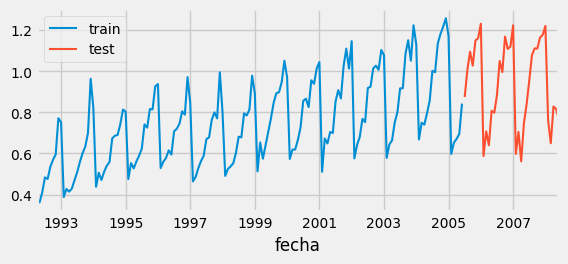

In [28]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend()

Error de test (mse): 0.07326833976120374
Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 0.02177319540541341

Error de test (mse) 0.004392699665157793


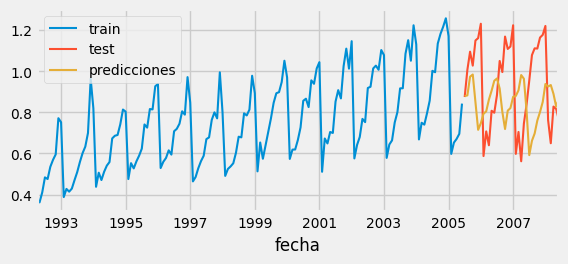

In [29]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )
forecaster.fit(y=datos_train['y'])
forecaster
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster.predict(steps=steps)
# Gráfico de predicciones vs valores reales
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend()
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

# Búsqueda de hiperparámetros: grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Valores candidatos de lags
lags_grid = [10, 20]

# Valores candidatos de hiperparámetros del regresor
param_grid = {
      'n_estimators': [100, 250],
      'max_depth': [3, 5, 10]
}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False
                  )

# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)

forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )
forecaster.fit(y=datos_train['y'])
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse) {error_mse}")


ForecasterAutoregDirect


Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': 0.2782559402207126}
  Backtesting metric: 0.02741394826520458



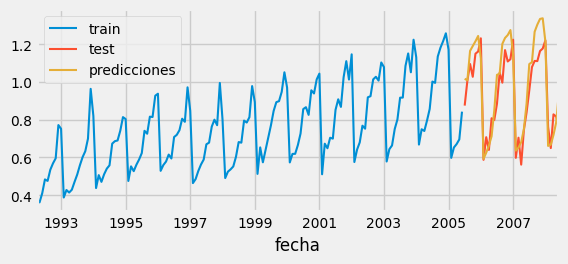

In [30]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor     = Ridge(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8
             )

forecaster

# Búsqueda de hiperparámetros
# ==============================================================================
from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

forecaster = ForecasterAutoregDirect(
                regressor     = Ridge(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8 # Este valor será remplazado en el grid search
             )
param_grid = {'alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]

resultados_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = datos_train['y'],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = 36,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    initial_train_size = int(len(datos_train)*0.5),
                    fixed_train_size   = False,
                    return_best        = True,
                    n_jobs             = 'auto',
                    verbose            = False
                )
# Predicciones
# ==============================================================================
predicciones = forecaster.predict()

# Gráfico predicciones vs valores reales
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend()